
# Part 2 — Deep Q‑Learning on Atari (Breakout)

This notebook adapts tabular Q‑Learning to **Deep Q‑Learning** on Atari using a **Dueling Double DQN**.
It includes preprocessing to 84×84 grayscale, framestacking, experience replay, and a target network.

> **ROMs:** You must import Atari ROMs once on your machine. See the next cell.


In [12]:

# --- One-time ROM import instructions (run locally on your machine) ---
print("""
ROMs are not bundled. Steps (only once per machine):
  1) Ensure:
       pip install "gymnasium[atari]" --upgrade
  2) Obtain legal ROMs and place .bin files into a folder, e.g., /path/to/ROMs
  3) Import them into ale-py:
       python - <<'PY'
from ale_py.roms import utils
utils.import_roms('/path/to/ROMs')
print('Done importing ROMs.')
PY

Verify:
  python - <<'PY'
import gymnasium as gym
print([e.id for e in gym.envs.registry.values() if 'Breakout' in e.id])
PY
Expect to see: 'ALE/Breakout-v5'
""")



ROMs are not bundled. Steps (only once per machine):
  1) Ensure:
       pip install "gymnasium[atari]" --upgrade
  2) Obtain legal ROMs and place .bin files into a folder, e.g., /path/to/ROMs
  3) Import them into ale-py:
       python - <<'PY'
from ale_py.roms import utils
utils.import_roms('/path/to/ROMs')
print('Done importing ROMs.')
PY

Verify:
  python - <<'PY'
import gymnasium as gym
print([e.id for e in gym.envs.registry.values() if 'Breakout' in e.id])
PY
Expect to see: 'ALE/Breakout-v5'



In [13]:

import numpy as np, random, collections, os, time
import torch, torch.nn as nn
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
    USING_GYMNASIUM = True
except Exception:
    import gym
    USING_GYMNASIUM = False

import cv2
from collections import deque

def info_print(msg):
    print(f"[DQN] {msg}")


In [14]:

# --- Wrappers ---
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def reset(self, **kwargs):
        if USING_GYMNASIUM:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs); info = {}
        try:
            step_out = self.env.step(1)  # FIRE action
            if USING_GYMNASIUM:
                obs, _, term, trunc, _ = step_out
                if term or trunc: obs, info = self.env.reset(**kwargs)
            else:
                obs, _, done, _ = step_out
                if done: obs = self.env.reset(**kwargs)
        except Exception:
            pass
        return (obs, info) if USING_GYMNASIUM else obs

class Preprocess84(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84,84), dtype=np.uint8)
    def observation(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84,84), interpolation=cv2.INTER_AREA)
        return resized

class FrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env); self.k=k; self.frames=collections.deque(maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(k, shp[0], shp[1]), dtype=np.uint8)
    def reset(self, **kwargs):
        if USING_GYMNASIUM:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs); info = {}
        for _ in range(self.k): self.frames.append(obs)
        return (np.stack(self.frames, axis=0), info) if USING_GYMNASIUM else np.stack(self.frames, axis=0)
    def step(self, action):
        step_out = self.env.step(action)
        if USING_GYMNASIUM:
            obs, r, term, trunc, info = step_out
            self.frames.append(obs)
            return np.stack(self.frames, axis=0), r, term, trunc, info
        else:
            obs, r, done, info = step_out
            self.frames.append(obs)
            return np.stack(self.frames, axis=0), r, done, info


In [15]:

def make_atari_env(game_id="ALE/Breakout-v5", render_mode=None, sticky_actions=True):
    try:
        _ = gym.spec(game_id)
    except Exception:
        raise RuntimeError(f'Env "{game_id}" not found. Ensure "gymnasium[atari]" is installed and ROMs imported.')
    kwargs = {}
    if USING_GYMNASIUM:
        kwargs["render_mode"] = render_mode
        kwargs["repeat_action_probability"] = 0.25 if sticky_actions else 0.0
    env = gym.make(game_id, **kwargs)
    env = FireResetEnv(env); env = Preprocess84(env); env = FrameStack(env, k=4)
    return env


In [16]:

# --- Dueling DQN ---
class DuelingDQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
        )
        self.V = nn.Sequential(nn.Flatten(), nn.Linear(7*7*64, 512), nn.ReLU(), nn.Linear(512, 1))
        self.A = nn.Sequential(nn.Flatten(), nn.Linear(7*7*64, 512), nn.ReLU(), nn.Linear(512, n_actions))
    def forward(self, x):
        x = x.float()/255.0
        h = self.conv(x)
        V = self.V(h); A = self.A(h)
        return V + (A - A.mean(dim=1, keepdim=True))


In [17]:

class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.capacity = capacity; self.mem=[]; self.pos=0
    def push(self, s,a,r,s2,d):
        data=(s,a,r,s2,d)
        if len(self.mem) < self.capacity: self.mem.append(data)
        else: self.mem[self.pos]=data
        self.pos=(self.pos+1)%self.capacity
    def sample(self, batch_size):
        import random as _r
        batch = _r.sample(self.mem, batch_size)
        s,a,r,s2,d = map(np.array, zip(*batch))
        return s,a,r,s2,d
    def __len__(self): return len(self.mem)


In [18]:

def choose_device():
    if torch.cuda.is_available(): return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return "mps"
    return "cpu"


In [19]:

def train_dqn(game="ALE/Breakout-v5", total_steps=300_000, batch_size=32, gamma=0.99, lr=5e-5,
              eps_start=1.0, eps_end=0.05, eps_decay_steps=500_000, target_update=30_000,
              learn_start=50_000, replay_cap=1_000_000, seed=0):
    device = choose_device()
    rng = random.Random(seed); np.random.seed(seed); torch.manual_seed(seed)
    env = make_atari_env(game_id=game)
    nA = env.action_space.n

    online = DuelingDQN(nA).to(device)
    target = DuelingDQN(nA).to(device)
    target.load_state_dict(online.state_dict())
    opt = torch.optim.RMSprop(online.parameters(), lr=lr, alpha=0.95, eps=1e-2, centered=True)
    rb = ReplayBuffer(capacity=replay_cap)

    def epsilon(step): return max(eps_end, eps_start - (eps_start-eps_end)*step/eps_decay_steps)

    if USING_GYMNASIUM:
        s, _ = env.reset(seed=rng.randint(0, 10**9))
    else:
        s = env.reset(seed=rng.randint(0, 10**9))
    s = np.asarray(s, dtype=np.uint8)
    ep_return = 0.0; episode_returns=[]

    for step in range(1, total_steps+1):
        eps = epsilon(step)
        if rng.random() < eps:
            a = env.action_space.sample()
        else:
            with torch.no_grad():
                q = online(torch.from_numpy(s[None,...]).to(device))
                a = int(torch.argmax(q, dim=1).item())
        if USING_GYMNASIUM:
            s2, r, term, trunc, _ = env.step(a); done = term or trunc
        else:
            s2, r, done, _ = env.step(a)

        r_clip = float(np.sign(r))
        rb.push(s, a, r_clip, np.asarray(s2, dtype=np.uint8), done)
        s = s2; ep_return += r

        if done:
            episode_returns.append(ep_return)
            if USING_GYMNASIUM:
                s, _ = env.reset(seed=rng.randint(0, 10**9))
            else:
                s = env.reset(seed=rng.randint(0, 10**9))
            s = np.asarray(s, dtype=np.uint8); ep_return = 0.0

        if step > learn_start and len(rb) >= batch_size:
            bs, ba, br, bs2, bd = rb.sample(batch_size)
            bs = torch.from_numpy(bs).to(device)
            ba = torch.from_numpy(ba).long().to(device)
            br = torch.from_numpy(br).float().to(device)
            bs2 = torch.from_numpy(bs2).to(device)
            bd = torch.from_numpy(bd.astype(np.float32)).to(device)

            with torch.no_grad():
                next_actions = online(bs2).argmax(dim=1)
                next_q = target(bs2).gather(1, next_actions.view(-1,1)).squeeze(1)
                y = br + gamma * next_q * (1.0 - bd)

            q = online(bs).gather(1, ba.view(-1,1)).squeeze(1)
            loss = nn.SmoothL1Loss()(q, y)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(online.parameters(), 10.0)
            opt.step()

        if step % target_update == 0:
            target.load_state_dict(online.state_dict())

        if step % 10_000 == 0:
            recent = np.mean(episode_returns[-20:]) if len(episode_returns) >= 20 else (np.mean(episode_returns) if episode_returns else 0.0)
            info_print(f"Step {step:,} | eps={eps:.3f} | recent avg return={recent:.2f} | replay={len(rb)} | device={device}")

    return online, np.array(episode_returns, dtype=np.float32)


In [20]:

def evaluate_dqn(policy_net, game="ALE/Breakout-v5", episodes=10):
    device = choose_device()
    rng = random.Random(1)
    env = make_atari_env(game_id=game)
    scores = []
    for _ in range(episodes):
        if USING_GYMNASIUM:
            s, _ = env.reset(seed=rng.randint(0, 10**9))
        else:
            s = env.reset(seed=rng.randint(0, 10**9))
        done = False; total = 0.0
        while not done:
            with torch.no_grad():
                q = policy_net(torch.from_numpy(np.asarray(s)[None,...]).to(device))
                a = int(torch.argmax(q, dim=1).item())
            if USING_GYMNASIUM:
                s, r, term, trunc, _ = env.step(a); done = term or trunc
            else:
                s, r, done, _ = env.step(a)
            total += r
        scores.append(total)
    return float(np.mean(scores)), float(np.std(scores))


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


[DQN] Step 10,000 | eps=0.981 | recent avg return=1.15 | replay=10000 | device=cuda
[DQN] Step 20,000 | eps=0.962 | recent avg return=1.15 | replay=20000 | device=cuda
[DQN] Step 30,000 | eps=0.943 | recent avg return=1.30 | replay=30000 | device=cuda
[DQN] Step 40,000 | eps=0.924 | recent avg return=0.85 | replay=40000 | device=cuda
[DQN] Step 50,000 | eps=0.905 | recent avg return=1.30 | replay=50000 | device=cuda
Evaluation: mean return = 0.00 ± 0.00 (N=5)


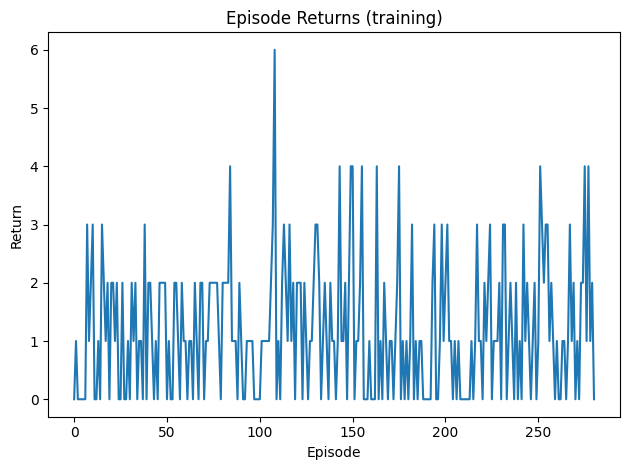

In [21]:

# === Demo run (adjust total_steps for real training) ===
total_steps = 50_000  # increase to 300_000+ for assignment-quality results
try:
    model, returns = train_dqn(total_steps=total_steps)
    avg, std = evaluate_dqn(model, episodes=5)
    print(f"Evaluation: mean return = {avg:.2f} ± {std:.2f} (N=5)")
    if len(returns) > 10:
        plt.plot(returns); plt.title("Episode Returns (training)"); plt.xlabel("Episode"); plt.ylabel("Return"); plt.tight_layout(); plt.show()
except RuntimeError as e:
    print("RuntimeError:", e)
    print("Please ensure ROMs are imported and 'ALE/Breakout-v5' is available.")
